In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

## About the data set:

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results
The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

--Solar radiation: watts per meter^2

--Temperature: degrees Fahrenheit

--Humidity: percent

--Barometric pressure: Hg

--Wind direction: degrees

--Wind speed: miles per hour

--Sunrise/sunset: Hawaii time

# Explore the data to gain insights

In [43]:
#Loading the data into a pandas data frame

Data = pd.read_csv("SolarPrediction.csv")
Data = Data.sort_values(['UNIXTime'], ascending = [True])
Data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [44]:
#Checking the data-type of the columns and if we have missing entries

Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 7416 to 24522
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 3.0+ MB


The most precise approach would be to make a model based on the given dava of time, date, unixtime, etc... But as we know, the others attributes are dependents of those (e.g. temp has a dependence on season), so to simplify our analysis we will just drop those attributes and try to find key features to create our model


So all the 'object' columns is not important neither is 'UNIXTime', let's drop them

*** Probably is a good idea to make an future analysis also based on time, maybe reasulting in a richer model or at least a richer visualization *** 

In [45]:
Data = Data.drop([
    'UNIXTime',
    'Data',
    'Time',
    'TimeSunRise',
    'TimeSunSet'],
    axis = 1) 

In [46]:
#Using the describe() method to gain some fast insights about the data

Data.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


The first thing we have to have in mind is what we want to do. Our goal in that project is to predict the level of solar radiation.

We can see that all entries are 'non-null' which will make our work easier.

We can also see that the standard deviation of 'Pressure' is pretty low and the standard deviation of 'Radiation' is the greater of all features. So, if Pressure is almost constant while Radiation has a high standard deviation, we can assume that pressure is not an important feature to our goal.

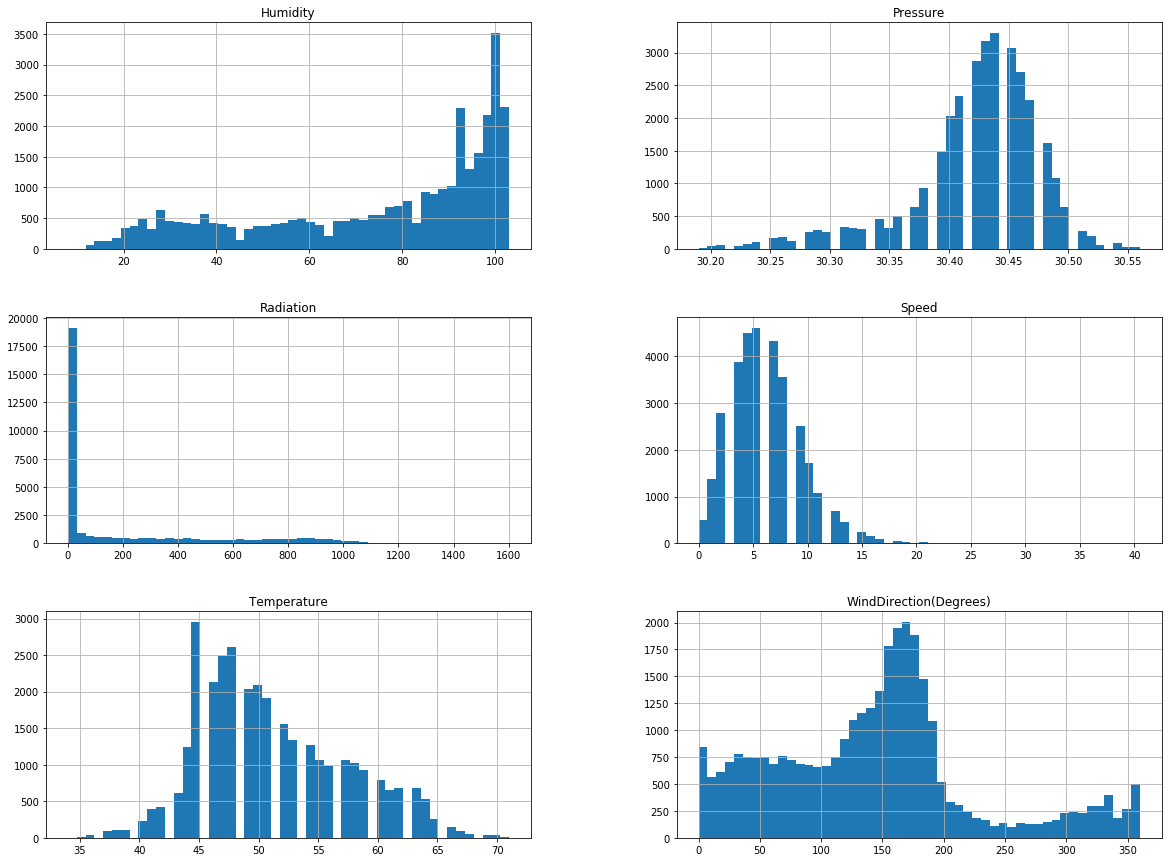

In [47]:
#Plotting a histogram of each numerical feature in order to gain more insights

Data.hist(bins=50, figsize=(20,15))
plt.show()

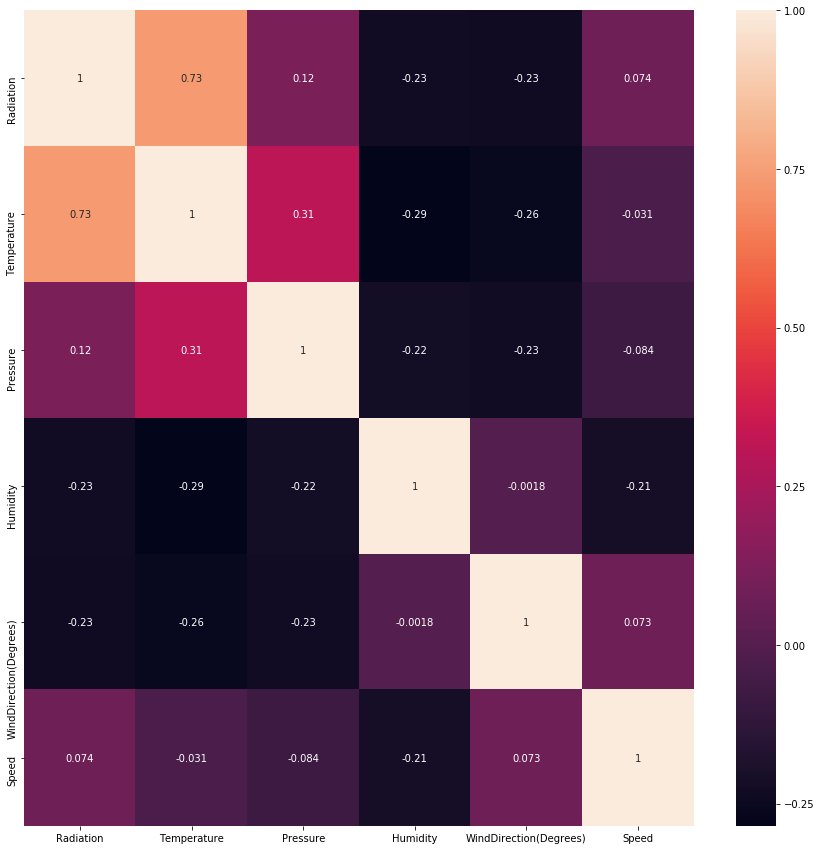

In [48]:
#Creating a correlation heatmap using seaborn

cor = Data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True)

With that correlation heatmap it's easier to see wich feature is most important for the model we want to create.

As you can see the highest correlation (magnitude) with Radiation is 'Temperature' (pos. correlated, 0.73), followed by 'Humidity' and 'WindDirection' (both neg. correlated, -0.23)

Let's plot those attributes

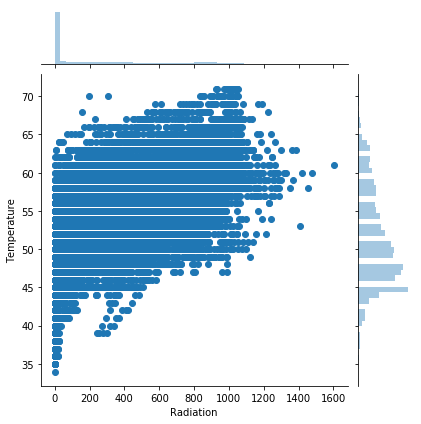

In [49]:
sns.jointplot(x="Radiation", y="Temperature", data=Data)

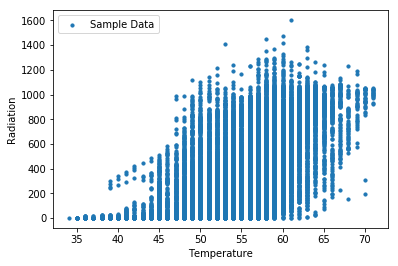

In [50]:
plt.scatter(Data['Temperature'].values, Data['Radiation'].values, label='Sample Data', s=10)
plt.xlabel('Temperature')
plt.ylabel('Radiation')
plt.legend()
plt.show()

Since the temperature is probably the most important feature for the prediction, it is important to retain it's distribution in both the training and test sets. We do that by applying stratified sampling.

First, we convert the continuous variable into a set of categories.

Text(0.5, 1.0, 'Temperature_Strat')

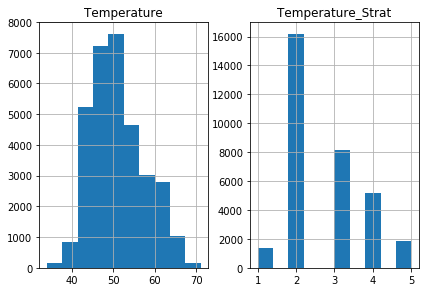

In [61]:
Data["Temperature_Strat"] = pd.cut(Data["Temperature"], bins = [0., 42, 50, 56, 62, np.inf], labels = [1,2,3,4,5])

fig, axes = plt.subplots(1, 2)
fig.tight_layout()

Data['Temperature'].hist(ax=axes[0])
Data["Temperature_Strat"].hist(ax=axes[1])

axes[0].set_title('Temperature')
axes[1].set_title('Temperature_Strat')

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

In [85]:
for train_index, test_index in split.split(Data, Data["Temperature_Strat"]):
    strat_train_set = Data.iloc[train_index]
    strat_test_set = Data.iloc[test_index]

In [86]:
strat_train_set.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Temperature_Strat
19595,1.20,47,30.42,24,165.79,10.12,2
14095,253.91,61,30.38,84,292.42,2.25,4
20881,452.09,55,30.42,70,81.06,12.37,3
11670,1.15,47,30.44,36,164.51,6.75,2
870,1.21,48,30.43,67,161.98,9.00,2


In [87]:
# Checking the proportions of each category
ratio_Data = Data['Temperature_Strat'].value_counts() / len(Data['Temperature_Strat'])
ratio_strat_train_set = strat_train_set['Temperature_Strat'].value_counts() / len(strat_train_set['Temperature_Strat'])